In [45]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [46]:
#Constantes

L = 2 #[m]
q = 400 # [W/m^3]
Ta = 258 # [Kelvin]
i = 1000 # Nombre de pas du maillage spatial
p = 1000 # Nombre de pas du maillage temporel
ti = 0
tf = 400
dt = (tf-ti)/p
k = 1
h = 10
Xi = 0.75
Cv = 1000
rho = 2000
dL = 0.5 # [m]

In [47]:
#Conditions frontieres
# à x=0 : c1*T'(0)+c2*T(0) + c3 = 0 ; à x=L d1*T'(L) + d2*T(L) + d3 = 0
c1 = -k
c2 = h
c3 = -h*Ta
d1 = -k
d2 = -h
d3 = h*Ta


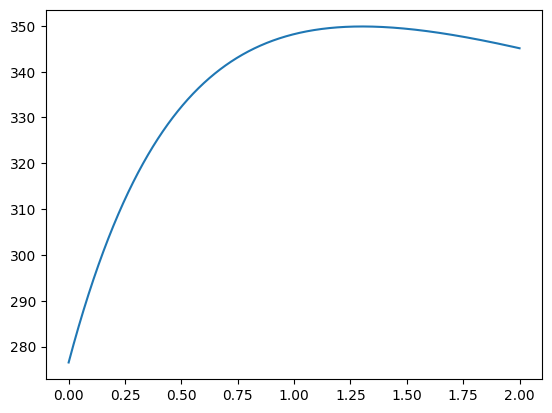

In [ ]:
#Initialisations
S=np.zeros(i+1,dtype=np.double)
A=np.zeros((i+1,i+1),dtype=np.double)
b=np.zeros(i+1,dtype=np.double)
u=np.zeros(i+1,dtype=np.double)

dx=L/i; #Pas de discrétisation
x=np.linspace(0,L,i+1)
S=q*np.exp(-x/dL)
u0=np.full(i+1,Ta,dtype=np.double)

A=np.diag(-2*np.ones(i+1),0)+np.diag(np.ones(i),-1)+np.diag(np.ones(i),1)
A[0,0]=(2*c2*dx-3*c1)*Xi;A[0,1]=(4*c1)*Xi;A[0,2]=-c1*Xi
A[i,i]=(3*d1+2*d2*dx)*Xi;A[i,i-1]=-4*d1*Xi;A[i,i-2]=d1*Xi
b=-S/k*dx**2; b[0]=-2*c3*dx-(2*c2*dx-3*c1)*(1-Xi)*u0[0]-4*c1*(1-Xi)*u0[1]+c1*(1-Xi)*u0[2]; b[i]=-2*d3*dx-d1*(1-Xi)*u0[i-2]+4*d1*(1-Xi)*u0[i-1]-(2*d2*dx+3*d1)*(1-Xi)*u0[i]
    
tic=time.time_ns()
u=np.linalg.solve(A, b); # Option préférée

toc=time.time_ns()
tInv=(toc-tic)/1e9; #temps en [s]   
    
Tmax=u.max()
plt.plot(x,u)

In [49]:
#Time dependancy


print(A.shape)


(1001, 1001)
